In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy


In [23]:
# Импорты библиотек
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ReLU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
# Загрузка данных
images = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
images_sub = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")
sample_submission = pd.read_csv("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv")

In [14]:
# Нормализация данных [0, 255] -> [0, 1]
images = images.astype("float32") / 255.0
images_sub = images_sub.astype("float32") / 255.0

In [15]:
# Вывод размеров выборок
print(f"Размер обучающих изображений: {images.shape}")
print(f"Размер меток: {labels.shape}")
print(f"Размер тестовых изображений: {images_sub.shape}")

Размер обучающих изображений: (20000, 48, 48, 3)
Размер меток: (20000,)
Размер тестовых изображений: (50000, 48, 48, 3)


In [16]:
# Проверка типа данных и диапазона
print(f"Диапазон пикселей после нормализации: {images.min()} - {images.max()}")

Диапазон пикселей после нормализации: 0.0 - 1.0


In [18]:
# One-hot encoding
num_classes = 26 # Количество букв в английском алфавите
labels_cat = to_categorical(labels, num_classes=num_classes)
print(f"Размер меток после One-Hot Encoding: {labels_cat.shape}")

Размер меток после One-Hot Encoding: (20000, 26)


In [21]:
# Разделение на train/val
X_train, X_val, y_train, y_val = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки (X_train): {X_train.shape}")
print(f"Размер валидационной выборки (X_val): {X_val.shape}")

Размер обучающей выборки (X_train): (16000, 48, 48, 3)
Размер валидационной выборки (X_val): (4000, 48, 48, 3)



Примеры обучающих изображений:


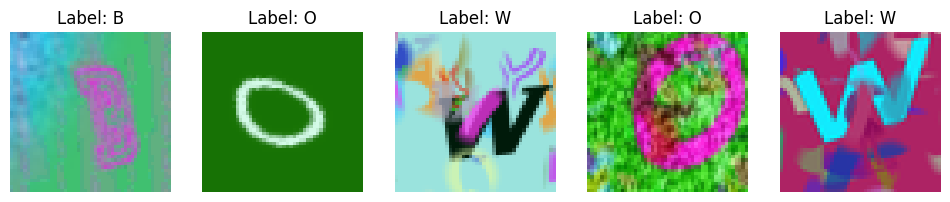

In [22]:
# Визуализация нескольких изображений
def plot_random_images(X, y, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        # Преобразуем one-hot обратно в класс, а затем в букву
        label = np.argmax(y[idx])
        plt.title(f"Label: {chr(65 + label)}") # 65 - ASCII код для 'A'
        plt.axis('off')
    plt.show()

print("\nПримеры обучающих изображений:")
plot_random_images(X_train, y_train)

In [36]:
# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=15,          # Случайный поворот на 15 градусов
    width_shift_range=0.1,      # Случайный сдвиг по горизонтали (10% от ширины)
    height_shift_range=0.1,     # Случайный сдвиг по вертикали (10% от высоты)
    shear_range=0.1,            # Случайное срезание (наклон)
    zoom_range=0.1,             # Случайное увеличение/уменьшение
    horizontal_flip=False,      # Не переворачиваем по горизонтали
    fill_mode='nearest'         # Стратегия заполнения новых пикселей
)
# Подготовка генератора данных
datagen.fit(X_train)

In [37]:
# Архитектура CNN с BatchNorm и ReLU
model = Sequential([
    Input(shape=(48, 48, 3)),

    # Блок 1
    # Модель учится находить базовые паттерны: простые линии, углы, границы (edge detectors)
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Блок 2
    # Модель учится находить базовые паттерны: комбинации линий — углы, части букв
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Блок 3
    # Сеть начинает "узнавать" части букв (например, "ножка A", "дуга B")
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),

    # Dense слой
    # После свёрток идёт Flatten() и Dense(512), где нейросеть уже обобщает всё увиденное и выбирает букву
    Flatten(),
    Dense(512),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

# Summery модели
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 12, 12, 128)         │              

 Total params: 2,663,994 (10.16 MB)

 Trainable params: 2,662,074 (10.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Компиляция
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
# Остановка, если модель "застряла". Используем early stopping для предотвращения переобучения
early_stop = EarlyStopping(
    patience=5,                 # Количество эпох без улучшения, после которых обучение остановится
    restore_best_weights=True)  # Восстанавливаем веса лучшей эпохи

# Уменьшение learning rate. Это помогает точнее "дожать" модель к финалу, когда шаги слишком большие
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  
    patience=3,                 # Если val_loss не улучшается 3 эпохи,
    factor=0.5,                 # он в 2 раза уменьшает скорость обучения (factor=0.5)
    verbose=1)

# Обучение
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),  # Обучающие данные с аугментацией
    epochs=40,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr]               # Добавляем early stopping
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.0433 - loss: 3.8681 - val_accuracy: 0.0388 - val_loss: 3.3178 - learning_rate: 1.0000e-04
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.0511 - loss: 3.5528 - val_accuracy: 0.0667 - val_loss: 3.2098 - learning_rate: 1.0000e-04
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.0751 - loss: 3.4318 - val_accuracy: 0.1185 - val_loss: 3.1005 - learning_rate: 1.0000e-04
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.0964 - loss: 3.2793 - val_accuracy: 0.1735 - val_loss: 2.9394 - learning_rate: 1.0000e-04
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.1433 - loss: 3.0516 - val_accuracy: 0.2808 - val_loss: 2.4658 - learning_rate: 1.0000e-04
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2467 - loss: 2.5845 - val_accuracy: 0.3388 - val_loss: 2.1908 - learning_rate: 1.0000e-04
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accurac

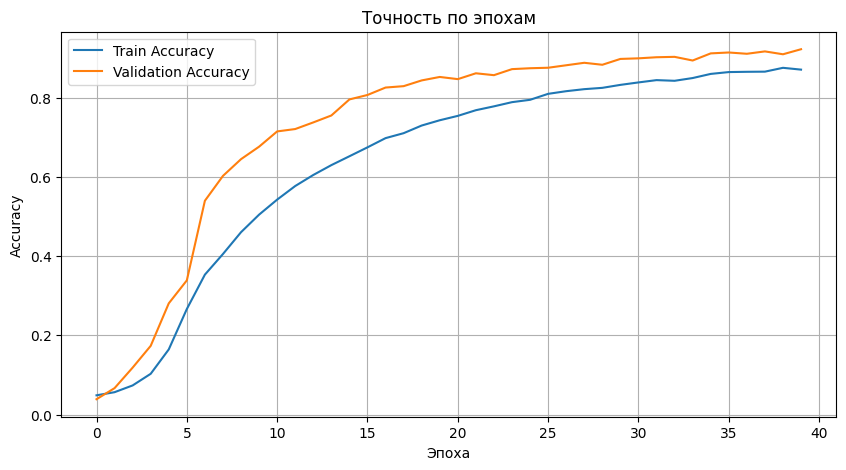

In [39]:
# График точности
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Предсказания
preds = model.predict(images_sub)
pred_labels = np.argmax(preds, axis=1)

# Формируем submission
submission = pd.DataFrame({
    "Id": np.arange(len(pred_labels)),
    "Category": pred_labels
})

submission.to_csv("submission.csv", index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
